In [9]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [10]:
# Set the data directory
data_dir = r'D:\Pictures\Samples\Robusta'

In [11]:
# Define the class labels
class_labels = ['Healthy', 'Cercospora', 'Leaf Rust', 'Coffee Wilt', 'Phoma']

In [12]:
# Define the data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a consistent size
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the images
])


In [13]:
# Define the custom dataset
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate over the class folders
        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                # Collect the image paths and labels
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and transform the image
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, label

In [14]:
# Create the dataset instances
train_dataset = CoffeeDataset(data_dir, transform=data_transforms)
val_dataset = CoffeeDataset(data_dir, transform=data_transforms)

In [15]:
# Split the dataset into training and validation sets (80% for training, 20% for validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


In [16]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 799
Length of validation dataset: 200


Training samples:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


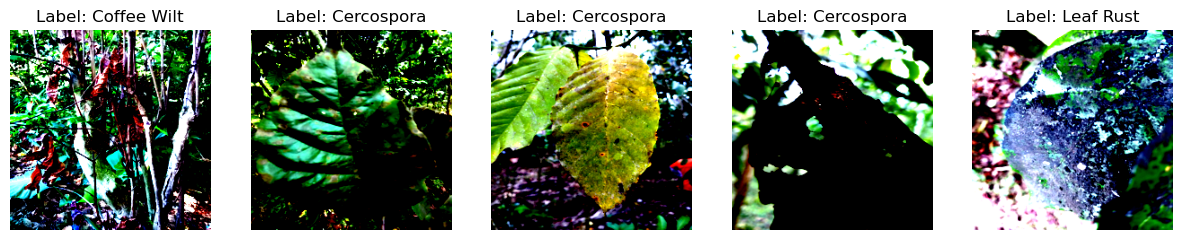

Validation samples:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


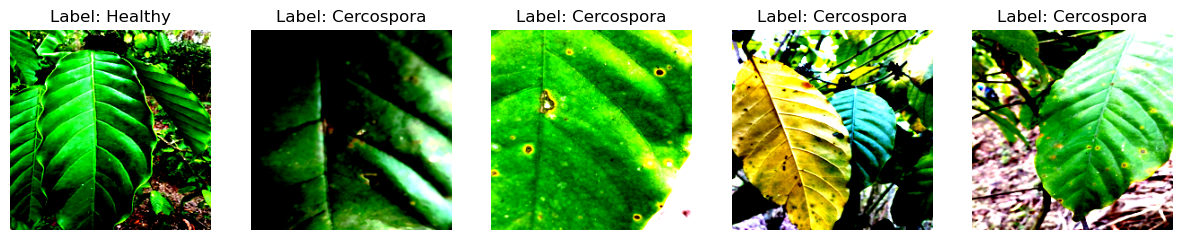

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize samples
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(f"Label: {class_labels[label]}")
        axes[i].axis('off')
    plt.show()

# Visualize training samples
print("Training samples:")
visualize_samples(train_dataset)

# Visualize validation samples
print("Validation samples:")
visualize_samples(val_dataset)

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models

In [30]:
# Load the pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)

In [31]:
# Freeze the parameters of the pre-trained layers
for param in resnet.parameters():
    param.requires_grad = False

In [32]:
# Replace the final fully connected layer with a new one for your classification task
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels)  # Assuming class_labels is defined
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [33]:
# Create the CNN model
model = resnet


In [34]:
# Check for available GPUs
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    print("GPU not available, using CPU")
    device = torch.device("cpu")


Using GPU: NVIDIA GeForce GTX 1650 Ti


In [35]:
# Move the model to the GPU
model = model.to(device)


In [36]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [37]:

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train Loss: 1.0590 Acc: 0.6496
val Loss: 0.8708 Acc: 0.7350
Epoch 2/25
----------
train Loss: 0.7047 Acc: 0.7635
val Loss: 0.6347 Acc: 0.8100
Epoch 3/25
----------
train Loss: 0.5555 Acc: 0.8285
val Loss: 0.5465 Acc: 0.8350
Epoch 4/25
----------
train Loss: 0.4767 Acc: 0.8448
val Loss: 0.4900 Acc: 0.8350
Epoch 5/25
----------
train Loss: 0.4160 Acc: 0.8598
val Loss: 0.4626 Acc: 0.8550
Epoch 6/25
----------
train Loss: 0.4024 Acc: 0.8736
val Loss: 0.4096 Acc: 0.8600
Epoch 7/25
----------
train Loss: 0.3428 Acc: 0.8899
val Loss: 0.3817 Acc: 0.8600
Epoch 8/25
----------
train Loss: 0.3310 Acc: 0.8861
val Loss: 0.3857 Acc: 0.8700
Epoch 9/25
----------
train Loss: 0.3086 Acc: 0.9011
val Loss: 0.3685 Acc: 0.8700
Epoch 10/25
----------
train Loss: 0.2913 Acc: 0.9111
val Loss: 0.3491 Acc: 0.8700
Epoch 11/25
----------
train Loss: 0.2719 Acc: 0.9049
val Loss: 0.3657 Acc: 0.8650
Epoch 12/25
----------
train Loss: 0.2508 Acc: 0.9161
val Loss: 0.3366 Acc: 0.8700
Epoch 13/25
-

In [44]:
def predict_image(image_path, model):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return class_labels[predicted]

image_path = "Healthy.jpg"  
print("Predicted Class: ", predict_image(image_path, model))

Predicted Class:  Healthy
